In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

plt.rcParams['figure.figsize'] = 15, 7

In [2]:
# Reading in Training set from 2011
data_2011 = pd.read_csv('../data/train_master_imputed_dummified.csv')

# Note: The index was copied into a column for some reason? 
# ALSO! We still have DRate Transformed... So I am dropping that too!
data_2011 = data_2011.drop('Unnamed: 0', axis=1)
data_2011 = data_2011.drop('DRate_Transformed', axis=1)

# Setting INSTNAME to index and dropping the UNITID (we can use this later if we want)
data_2011 = data_2011.set_index('INSTNAME')
data_2011 = data_2011.drop('UNITID', axis=1)

data_2011.columns = [column.replace(' ', '_') for column in data_2011.columns]
data_2011.columns = [column.replace('\n', '_') for column in data_2011.columns]

In [45]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

linear_sklearn = LinearRegression(fit_intercept=True)
linear_sklearn = linear_sklearn.fit(data_2011.drop('DRate', axis=1), data_2011['DRate'])

print("~~~ Baseline OLS ~~~")
print('OLS MSE: ', metrics.mean_squared_error(data_2011['DRate'], 
                                              linear_sklearn.predict(data_2011.drop('DRate', axis=1)))**0.5
     )
print('OLS R2:', linear_sklearn.score(data_2011.drop('DRate', axis=1), data_2011['DRate']))

~~~ Baseline OLS ~~~
OLS MSE:  6.52474981171
OLS R2: 0.414432576496


In [ ]:
# pprint([i for i in sorted(set(data_2011['STICKER_PRICE_SHARE'].values))])
# for row in data_2011.loc['Columbia College', :].values:

In [3]:
# for i in set(data_2011['GROFFER'].values):
#     subset_i = data_2011[data_2011['GROFFER'] == i]
#     for j in set(data_2011['ICLEVEL_y__1'].values):
#         subset_i_j = subset_i[subset_i['ICLEVEL_y__1'] == j]
#         mean = np.mean(subset_i_j['DRate'])
#         print(i, j, mean)
        
data_2011 = data_2011.drop(['GROFFER', 'Prog_Length__8', 'ICLEVEL_x__1'], axis=1)

### Note: we dropped leading feature `GROFFER` for model interpretability and (negative) correlation with `ICLEVEL_y__1`. Be sure to include that in final paper.

### Note: we also dropped `Prog\nLength__8` because it was a proxy for `GROFFER`. See above as to why we didn't include `GROFFER`.

### Note: we *also* dropped `ICLEVEL_x__1` because it was likely a proxy for `ICLEVEL_y__1`. Each came from a different dataset but was supposed to be representing the same value.

In [4]:
from sklearn import tree
from sklearn import ensemble

target = 'DRate'

# Isolate training and testing data frames on 80/20 split
train_df = data_2011.sample(frac = 0.80, replace = False)
test_df = data_2011.drop(train_df.index)

# Split each into training and testing data frames
train_X, train_y = train_df.drop(target, axis = 1), train_df[target]
test_X, test_y = test_df.drop(target, axis = 1), test_df[target]

# We will first test out our feature importance via a decision tree, then see what happens with the Random Forrest.
rfr = ensemble.RandomForestRegressor(n_estimators=300, n_jobs=-1)
decisionTree = tree.DecisionTreeRegressor()

#Fitting:
rfr = rfr.fit(train_X, train_y)
decisionTree = decisionTree.fit(train_X,train_y)

#### Disclaimer: None of these feature importances tell us about Direction (see hw 3 I think)... More models must be built.

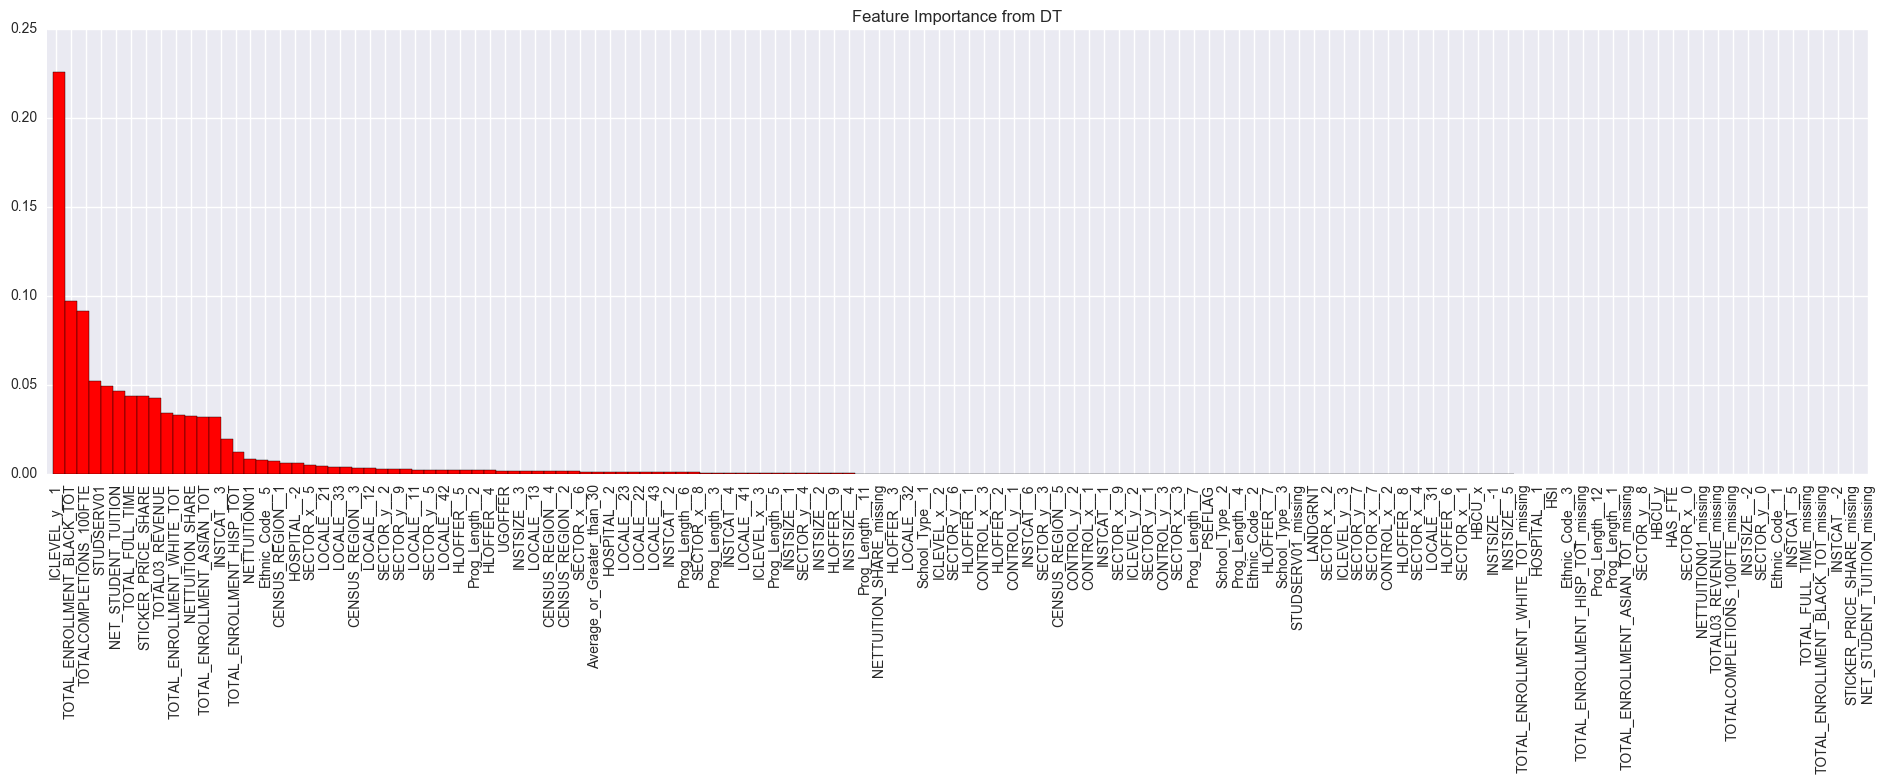

In [5]:
# Feature importance for Decision Tree Regressor
# NOTE: we really have to play with the X-Tick distances and bar widths....

# Sort our classifier's feature importance vector
indices_decisionTree = np.argsort(decisionTree.feature_importances_)[::-1]

# Plot our features in order of importance to our decision tree regressor
fig = plt.figure(figsize=(19,8))
ax = plt.subplot(111)
width = 1
ax.bar(.5 + np.arange(len(decisionTree.feature_importances_)), sorted(decisionTree.feature_importances_, reverse = True), width, color = 'r')
ax.set_xticks(.75 + np.arange(len(decisionTree.feature_importances_)) * 1.25)
ax.set_xticklabels([train_X.columns[i] for i in indices_decisionTree], rotation = 90)
plt.title('Feature Importance from DT')
fig.tight_layout()
plt.savefig("feature_importance.png")

In [6]:
# So! These are the Most important features. The first 15 are the most important and the importance appears to
# drop off after that...

# [train_X.columns[i] for i in indices_decisionTree]

In [7]:
[train_X.columns[i] for i in indices_decisionTree][:15]

['ICLEVEL_y__1',
 'TOTAL_ENROLLMENT_BLACK_TOT',
 'TOTALCOMPLETIONS_100FTE',
 'STUDSERV01',
 'NET_STUDENT_TUITION',
 'TOTAL_FULL_TIME',
 'STICKER_PRICE_SHARE',
 'TOTAL03_REVENUE',
 'TOTAL_ENROLLMENT_WHITE_TOT',
 'NETTUITION_SHARE',
 'TOTAL_ENROLLMENT_ASIAN_TOT',
 'INSTCAT__3',
 'TOTAL_ENROLLMENT_HISP_TOT',
 'NETTUITION01',
 'Ethnic_Code__5']

### Notes: 

It seems that the institution offering Graduate Programs is by far the leading indicator in reducing MSE of the Default Rates. If a school does not offer grad programs, then the value is 2.

Additionally, it is very interesting that the second impactful feature was Total Enrollment of Black students... Especially considering that in nearly every test we did not find HBCUs to be important at all! Makes a really solid case for HBCUs...

Sticker price is on there, so that's interesting. 

Control_x_2 is defined as schools that are private non-profit institutions

Ethnic Code_5 is defined as schools that did not report an ethnic code (this makes up a lot of the data... Not an HBCU or any other affiliation)


In [8]:
indices_decisionTree = np.argsort(decisionTree.feature_importances_)[::-1]
importance_decisionTree = {train_X.columns[i]: i for i in indices_decisionTree}
importance_decisionTree

{'Average_or_Greater_than_30': 4,
 'CENSUS_REGION__1': 32,
 'CENSUS_REGION__2': 33,
 'CENSUS_REGION__3': 34,
 'CENSUS_REGION__4': 35,
 'CENSUS_REGION__5': 36,
 'CONTROL_x__1': 37,
 'CONTROL_x__2': 38,
 'CONTROL_x__3': 39,
 'CONTROL_y__1': 43,
 'CONTROL_y__2': 44,
 'CONTROL_y__3': 45,
 'Ethnic_Code__1': 65,
 'Ethnic_Code__2': 66,
 'Ethnic_Code__3': 67,
 'Ethnic_Code__5': 68,
 'HAS_FTE': 7,
 'HBCU_x': 0,
 'HBCU_y': 5,
 'HLOFFER__1': 91,
 'HLOFFER__2': 92,
 'HLOFFER__3': 93,
 'HLOFFER__4': 94,
 'HLOFFER__5': 95,
 'HLOFFER__6': 96,
 'HLOFFER__7': 97,
 'HLOFFER__8': 98,
 'HLOFFER__9': 99,
 'HOSPITAL__-2': 69,
 'HOSPITAL__1': 70,
 'HOSPITAL__2': 71,
 'HSI': 6,
 'ICLEVEL_x__2': 46,
 'ICLEVEL_x__3': 47,
 'ICLEVEL_y__1': 119,
 'ICLEVEL_y__2': 120,
 'ICLEVEL_y__3': 121,
 'INSTCAT__-2': 58,
 'INSTCAT__1': 59,
 'INSTCAT__2': 60,
 'INSTCAT__3': 61,
 'INSTCAT__4': 62,
 'INSTCAT__5': 63,
 'INSTCAT__6': 64,
 'INSTSIZE__-1': 73,
 'INSTSIZE__-2': 72,
 'INSTSIZE__1': 74,
 'INSTSIZE__2': 75,
 'INSTSIZE__3

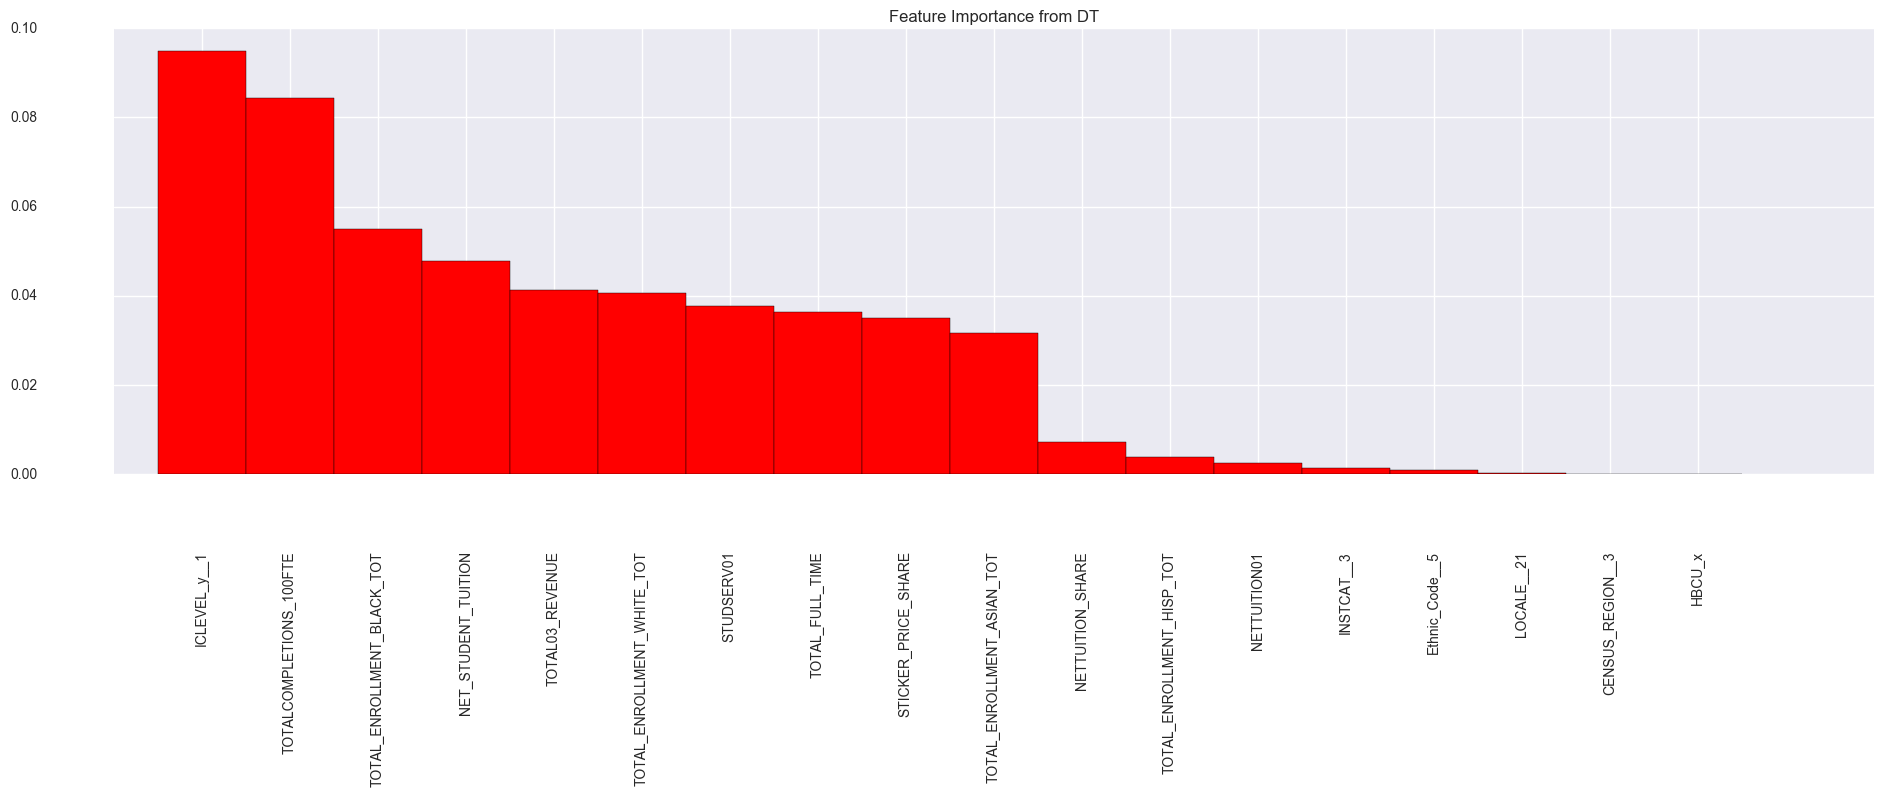

In [12]:
# Feature importance for Random Forrest Regressor
# NOTE: we really have to play with the X-Tick distances and bar widths....

# Sort our classifier's feature importance vector
indices_rfr = np.argsort(rfr.feature_importances_)[::-1]

# Plot our features in order of importance to our decision tree regressor
fig = plt.figure(figsize=(19,8))
ax = plt.subplot(111)
width = 1
# ax.bar(.5 + np.arange(len(rfr.feature_importances_)), sorted(rfr.feature_importances_, reverse = True), width, color = 'r')
ax.bar(0.5 + np.arange(18), sorted(rfr.feature_importances_[:18], reverse=True), width, color = 'r')
ax.set_xticks(1 + np.arange(18))
ax.set_xticklabels([train_X.columns[i] for i in indices_rfr[:18]], rotation = 90)
ax.tick_params(axis='both', which='major', pad=55)
fig.tight_layout()
plt.title('Feature Importance from DT')
plt.savefig("top_feature_importance.png")

In [10]:
indices_rfr = np.argsort(rfr.feature_importances_)[::-1]
importance_rfr = {train_X.columns[i]: i for i in indices_rfr}
importance_rfr

{'Average_or_Greater_than_30': 4,
 'CENSUS_REGION__1': 32,
 'CENSUS_REGION__2': 33,
 'CENSUS_REGION__3': 34,
 'CENSUS_REGION__4': 35,
 'CENSUS_REGION__5': 36,
 'CONTROL_x__1': 37,
 'CONTROL_x__2': 38,
 'CONTROL_x__3': 39,
 'CONTROL_y__1': 43,
 'CONTROL_y__2': 44,
 'CONTROL_y__3': 45,
 'Ethnic_Code__1': 65,
 'Ethnic_Code__2': 66,
 'Ethnic_Code__3': 67,
 'Ethnic_Code__5': 68,
 'HAS_FTE': 7,
 'HBCU_x': 0,
 'HBCU_y': 5,
 'HLOFFER__1': 91,
 'HLOFFER__2': 92,
 'HLOFFER__3': 93,
 'HLOFFER__4': 94,
 'HLOFFER__5': 95,
 'HLOFFER__6': 96,
 'HLOFFER__7': 97,
 'HLOFFER__8': 98,
 'HLOFFER__9': 99,
 'HOSPITAL__-2': 69,
 'HOSPITAL__1': 70,
 'HOSPITAL__2': 71,
 'HSI': 6,
 'ICLEVEL_x__2': 46,
 'ICLEVEL_x__3': 47,
 'ICLEVEL_y__1': 119,
 'ICLEVEL_y__2': 120,
 'ICLEVEL_y__3': 121,
 'INSTCAT__-2': 58,
 'INSTCAT__1': 59,
 'INSTCAT__2': 60,
 'INSTCAT__3': 61,
 'INSTCAT__4': 62,
 'INSTCAT__5': 63,
 'INSTCAT__6': 64,
 'INSTSIZE__-1': 73,
 'INSTSIZE__-2': 72,
 'INSTSIZE__1': 74,
 'INSTSIZE__2': 75,
 'INSTSIZE__3

In [11]:
top_18 = [train_X.columns[i] for i in indices_rfr][:18]
top_18

['ICLEVEL_y__1',
 'TOTALCOMPLETIONS_100FTE',
 'TOTAL_ENROLLMENT_BLACK_TOT',
 'NET_STUDENT_TUITION',
 'TOTAL03_REVENUE',
 'TOTAL_ENROLLMENT_WHITE_TOT',
 'STUDSERV01',
 'TOTAL_FULL_TIME',
 'STICKER_PRICE_SHARE',
 'TOTAL_ENROLLMENT_ASIAN_TOT',
 'NETTUITION_SHARE',
 'TOTAL_ENROLLMENT_HISP_TOT',
 'NETTUITION01',
 'INSTCAT__3',
 'Ethnic_Code__5',
 'LOCALE__21',
 'CENSUS_REGION__3',
 'HBCU_x']

In [ ]:
# Take a look at the top 18:

top_18 = [train_X.columns[i] for i in indices_rfr][:18]
top_18

### Notes:

**Some different results!**

Schools that offer Grad Programs have lower Default Rates

Completions went up, ICILevel shot way up, Total Revenue too, and so did Enrollment of White.

Control shot down significantly!

These features that are important seem to overlap with the regular decision tree, but this model seems to benefit 
from all of the random sampling (bagging).

ICILevel_y_1 is defined as an institution that is a four year college!

In [ ]:
sns.pairplot(data_2011[['TOTALCOMPLETIONS_100FTE','DRate']])

In [ ]:
# Plotting pair-wise plots for each feature that we indicated had large importance to see what the data looks like!

for feature in top_18:
    sns.pairplot(data_2011[[feature,'DRate']])

In [ ]:
zero_DRate = data_2011[data_2011['DRate']==0]
np.mean(zero_DRate.STICKER_PRICE_SHARE)

In [ ]:
high_DRate = data_2011[data_2011['DRate']>10]
np.mean(high_DRate.STICKER_PRICE_SHARE)

#### Random note above ^ there is an inverse relationship between burden of StickerPrice and Default Rates

#### Also, the mean was imputed to be over 100%... Unclear as to what over 100% of share of education and related expenses that are covered by gross tuition revenue

In [13]:
top_18_wDRate = top_18+['DRate']

In [14]:
corr_matrix = data_2011[top_18_wDRate].corr()[-1:]
corr_matrix.transpose()

,DRate
ICLEVEL_y__1,-0.480295
TOTALCOMPLETIONS_100FTE,0.103107
TOTAL_ENROLLMENT_BLACK_TOT,0.045287
NET_STUDENT_TUITION,-0.242946
TOTAL03_REVENUE,-0.174075
TOTAL_ENROLLMENT_WHITE_TOT,-0.078089
STUDSERV01,-0.161005
TOTAL_FULL_TIME,-0.120929
STICKER_PRICE_SHARE,-0.005018
TOTAL_ENROLLMENT_ASIAN_TOT,-0.057892


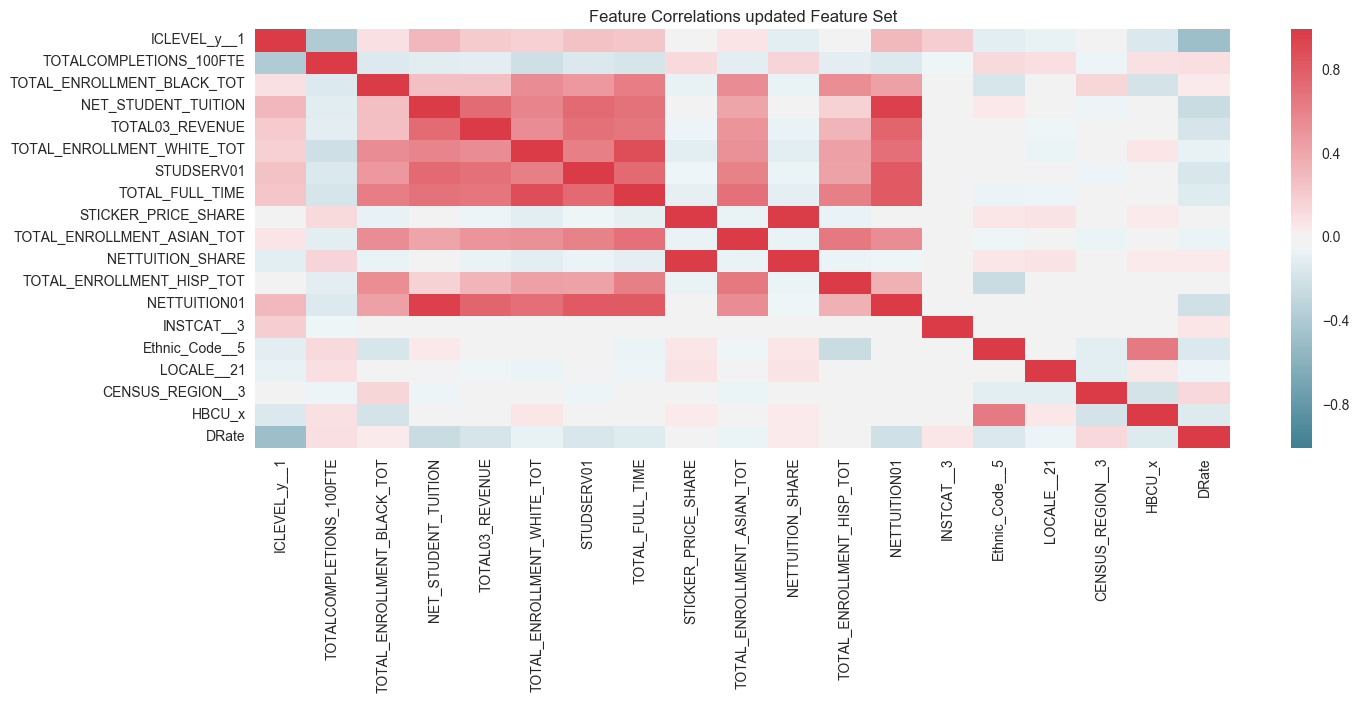

In [19]:
# Fancy heatmap!

cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr_matrix = data_2011[top_18_wDRate].corr()
cmap_plt = sns.heatmap(corr_matrix, cmap=cmap)
fig = cmap_plt.get_figure()
fig.tight_layout()
plt.title('Feature Correlations updated Feature Set')
fig.savefig("feature-heatmap.png")

#### Leading into our next model (/if we would like to move forward with a more basic linear model) this gives some insight to correlations

#### We must watch out for redundent and highly correlated features like: 
**ICLEVEL_y__1 and GROFFER , 

TOTAL_FULL_TIME and MANY, 

ALL CONTROL FEATURES that repeat, 

NET_STUDENT_TUITION and NETTUITION01**

ALSO! Lol that TOTAL FULL TIME STUDENTS and TOTAL WHITE are positively correlated 

In [ ]:
# Attempt at SVD:

U, sig, Vt = np.linalg.svd(data_2011)

#Plot the spectrum of the image and the total sum-squares captured by the k-th value

# norm = math.sqrt(sum(sig*sig))
# energy_k = [math.sqrt(k)/norm for k in math.cumsum(sig*sig)]

# plt.figure()
# ax1 = plt.subplot(211)
# plt.plot(sig)
# plt.title('Kth Singular Value')
# plt.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')


# ax2 = plt.subplot(212)
# plt.plot(energy_k)
# plt.title('Normalized Cumulative Energy of Kth Singular Value')

# ax2.set_xlabel('Kth Singular Value')
# sig

In [20]:
top_18_test = top_18
# top_18.remove('Ethnic Code__5')

In [21]:
top_18_test

['ICLEVEL_y__1',
 'TOTALCOMPLETIONS_100FTE',
 'TOTAL_ENROLLMENT_BLACK_TOT',
 'NET_STUDENT_TUITION',
 'TOTAL03_REVENUE',
 'TOTAL_ENROLLMENT_WHITE_TOT',
 'STUDSERV01',
 'TOTAL_FULL_TIME',
 'STICKER_PRICE_SHARE',
 'TOTAL_ENROLLMENT_ASIAN_TOT',
 'NETTUITION_SHARE',
 'TOTAL_ENROLLMENT_HISP_TOT',
 'NETTUITION01',
 'INSTCAT__3',
 'Ethnic_Code__5',
 'LOCALE__21',
 'CENSUS_REGION__3',
 'HBCU_x']

In [22]:
string_features = ""
string_features = ' + '.join(top_18)
# for feature in top_18:
print(string_features)

ICLEVEL_y__1 + TOTALCOMPLETIONS_100FTE + TOTAL_ENROLLMENT_BLACK_TOT + NET_STUDENT_TUITION + TOTAL03_REVENUE + TOTAL_ENROLLMENT_WHITE_TOT + STUDSERV01 + TOTAL_FULL_TIME + STICKER_PRICE_SHARE + TOTAL_ENROLLMENT_ASIAN_TOT + NETTUITION_SHARE + TOTAL_ENROLLMENT_HISP_TOT + NETTUITION01 + INSTCAT__3 + Ethnic_Code__5 + LOCALE__21 + CENSUS_REGION__3 + HBCU_x


In [24]:
import statsmodels.formula.api as smf

lm = smf.ols(formula='DRate ~ ' + string_features, data=data_2011).fit()

#print the full summary
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  DRate   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     124.1
Date:                Sat, 10 Dec 2016   Prob (F-statistic):               0.00
Time:                        11:04:05   Log-Likelihood:                -14157.
No. Observations:                4227   AIC:                         2.835e+04
Df Residuals:                    4208   BIC:                         2.847e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                     34.1808      1.779     19.209      0.000        30.692    37.669
ICLEVEL_y__1                  -8.8705      0.301    -29.425      0.000        -9.462    -8.280
TOTALCOMPLETIONS_100FTE       -0.0117      0.003     -4.310      0.000        -0.017    -0.006
TOTAL_ENROLLMENT_BLACK_TOT -6.123e-05      0.000     -0.604      0.546        -0.000     0.000
NET_STUDENT_TUITION        -7.685e-08   1.19e-08     -6.468      0.000        -1e-07 -5.36e-08
TOTAL03_REVENUE            -9.267e-10   3.72e-10     -2.491      0.013     -1.66e-09 -1.97e-10
TOTAL_ENROLLMENT_WHITE_TOT     0.0002   4.96e-05      3.957      0.000       9.9e-05     0.000
STUDSERV01                 -8.959e-09   1.44e-08     -0.622      0.534     -3.72e-08  1.93e-08
TOTAL_FULL_TIME               -0.0003   6.92e-05     -3.719      0.000        -0.000    -0.000
STICKER_PRICE_SHARE           -2.1723      0.723     -3.006      0.003        -3.589    -0.756
TOTAL_ENROLLMENT_ASIAN_TOT    -0.0002      0.000     -1.052      0.293        -0.000     0.000
NETTUITION_SHARE               2.2570      0.725      3.114      0.002         0.836     3.678
TOTAL_ENROLLMENT_HISP_TOT  -8.915e-05   6.87e-05     -1.297      0.195        -0.000  4.56e-05
NETTUITION01                7.473e-08   1.28e-08      5.860      0.000      4.97e-08  9.97e-08
INSTCAT__3                     6.3849      0.544     11.728      0.000         5.318     7.452
Ethnic_Code__5                -4.0334      0.718     -5.616      0.000        -5.442    -2.625
LOCALE__21                    -1.3468      0.264     -5.093      0.000        -1.865    -0.828
CENSUS_REGION__3               1.5743      0.238      6.606      0.000         1.107     2.042
HBCU_x                        -6.7791      1.075     -6.305      0.000        -8.887    -4.671
==============================================================================
Omnibus:                      459.312   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1431.061
Skew:                           0.561   Prob(JB):                    1.77e-311
Kurtosis:                       5.620   Cond. No.                     9.97e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.97e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Possible next steps:

1) Drop all highely correlated X variables [ie. Control_x__2 and control_y__2 , NET_STUDENT_TUITION and NETTUITION01, 
    Others.
    
2) Maybe play with dropping features and re-running regressions. Classic way to truly test for Causal inference (as in introducing some treatment). For example, we could drop GROFFER and re-run or Drop Sticker-Price... Testing for Proxy-Variables. 

3) Try another regression. A Ridge could be great!!! (http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html with an L2 Regularization!!)


In [25]:
ridge = smf.ols(formula='DRate ~ ' + string_features, data=data_2011).fit_regularized(L1_wt=0)

In [26]:
ridge.summary()

/Users/danny/miniconda3/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1263: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/danny/miniconda3/lib/python3.5/site-packages/statsmodels/base/model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/danny/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/danny/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/danny/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  DRate   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     121.7
Date:                Sat, 10 Dec 2016   Prob (F-statistic):               0.00
Time:                        11:04:12   Log-Likelihood:                -14172.
No. Observations:                4227   AIC:                         2.838e+04
Df Residuals:                    4208   BIC:                         2.850e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                     33.2183      1.783     18.630      0.000        29.723    36.714
ICLEVEL_y__1                  -8.8542      0.302    -29.315      0.000        -9.446    -8.262
TOTALCOMPLETIONS_100FTE       -0.0117      0.003     -4.290      0.000        -0.017    -0.006
TOTAL_ENROLLMENT_BLACK_TOT -4.669e-05   9.99e-05     -0.467      0.640        -0.000     0.000
NET_STUDENT_TUITION        -7.641e-08   1.12e-08     -6.837      0.000     -9.83e-08 -5.45e-08
TOTAL03_REVENUE                    -0          0        nan        nan            -0         0
TOTAL_ENROLLMENT_WHITE_TOT     0.0002   4.94e-05      3.895      0.000      9.57e-05     0.000
STUDSERV01                         -0          0        nan        nan            -0         0
TOTAL_FULL_TIME               -0.0003    6.7e-05     -3.767      0.000        -0.000    -0.000
STICKER_PRICE_SHARE           -2.1960      0.724     -3.035      0.002        -3.615    -0.777
TOTAL_ENROLLMENT_ASIAN_TOT    -0.0002      0.000     -1.044      0.297        -0.000     0.000
NETTUITION_SHARE               2.2808      0.726      3.142      0.002         0.858     3.704
TOTAL_ENROLLMENT_HISP_TOT     -0.0001   6.89e-05     -1.474      0.141        -0.000  3.35e-05
NETTUITION01                7.414e-08   1.16e-08      6.416      0.000      5.15e-08  9.68e-08
INSTCAT__3                     6.3687      0.545     11.675      0.000         5.299     7.438
Ethnic_Code__5                -4.3317      0.720     -6.013      0.000        -5.744    -2.919
LOCALE__21                    -1.3516      0.265     -5.094      0.000        -1.872    -0.831
CENSUS_REGION__3               1.5858      0.238      6.659      0.000         1.119     2.053
HBCU_x                        -6.1538      1.077     -5.712      0.000        -8.266    -4.042
==============================================================================
Omnibus:                      478.295   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1459.529
Skew:                           0.591   Prob(JB):                         0.00
Kurtosis:                       5.625   Cond. No.                          nan
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is -5.26e+04. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [27]:
# from statsmodels.regression.linear_model import RegressionResults

# res = RegressionResults(ridge)

In [28]:
from sklearn.metrics import mean_squared_error

alphas = np.logspace(-20, 10, 21)
alphas_RMSE = []

for alpha in alphas:
    ridge = smf.ols(formula='DRate ~ ' + string_features, data=data_2011).fit_regularized(L1_wt=0, alpha=alpha)
    ridge_RMSE = mean_squared_error(data_2011['DRate'], ridge.fittedvalues) ** 0.5
    alphas_RMSE.append(ridge_RMSE)

# lm_RMSE = mean_squared_error(data_2011['DRate'], lm.fittedvalues) ** 0.5
alphas_RMSE

lm_RMSE = mean_squared_error(data_2011['DRate'], lm.fittedvalues) ** 0.5

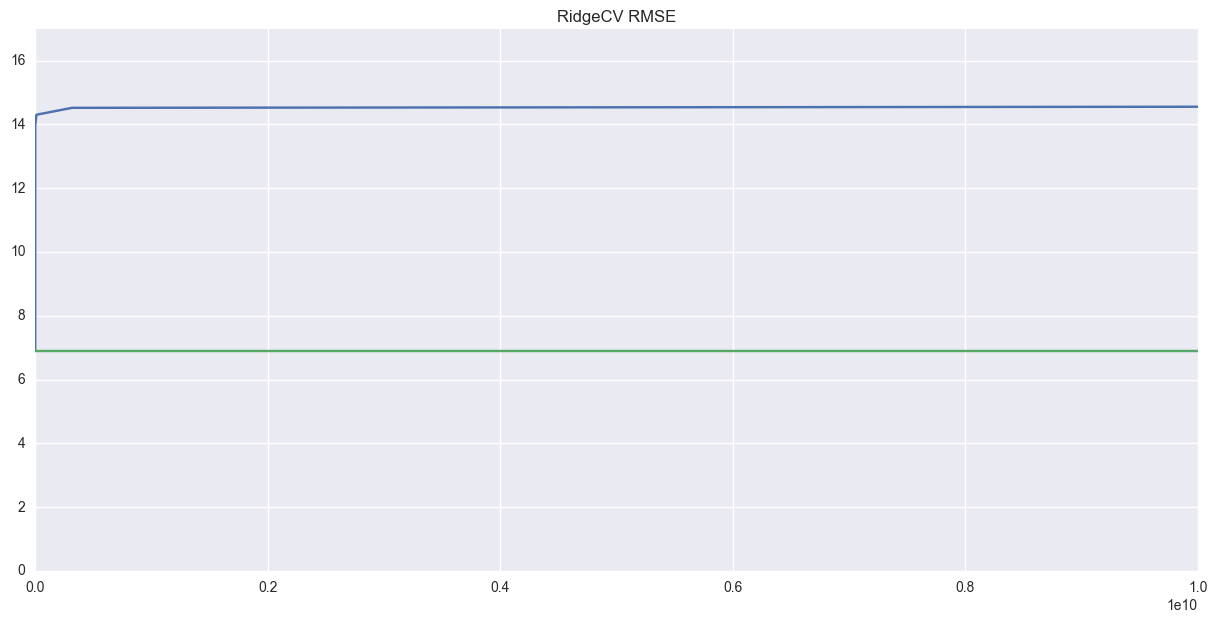

In [32]:
# TODO this plot of RMSE on hyper-parameterized model
fig, ax = plt.subplots()

plt.title("RidgeCV RMSE")
plt.plot(alphas, alphas_RMSE)
plt.plot(alphas, np.repeat(lm_RMSE, len(alphas_RMSE)))
plt.ylim([0, 17])
plt.show()

In [33]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

# ridge_cv = RidgeCV(cv = KFold(data_2011.shape[0], n_folds=5, shuffle=True))
# ridge_cv = ridge_cv.fit(data_2011[top_18], data_2011['DRate'])

grid_cv = GridSearchCV(
                       cv=KFold(data_2011.shape[0], n_folds=5, shuffle=True),
                       estimator=Ridge(), 
                       scoring='mean_squared_error',
                       param_grid = [{'alpha': alphas,
                                     'fit_intercept': [True, False]
                                     }]
                      )

grid_cv.fit(data_2011[top_18], data_2011['DRate'])

/Users/danny/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/danny/miniconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/danny/miniconda3/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users

GridSearchCV(cv=sklearn.cross_validation.KFold(n=4227, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([  1.00000e-20,   3.16228e-19,   1.00000e-17,   3.16228e-16,
         1.00000e-14,   3.16228e-13,   1.00000e-11,   3.16228e-10,
         1.00000e-08,   3.16228e-07,   1.00000e-05,   3.16228e-04,
         1.00000e-02,   3.16228e-01,   1.00000e+01,   3.16228e+02,
         1.00000e+04,   3.16228e+05,   1.00000e+07,   3.16228e+08,
         1.00000e+10]), 'fit_intercept': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [38]:
# Obtain Ridge model parameters
grid_cv.best_estimator_

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [39]:
# Convert MSE into RMSE
np.abs(grid_cv.best_score_) ** 0.5

7.0776733940497891

In [ ]:
# Now drop non-informative features.

data_dropped = data_2011.drop(['TOTAL_ENROLLMENT_BLACK_TOT', 'TOTAL03_REVENUE',
                               'STUDSERV01', 'TOTAL_FULL_TIME', 'TOTAL_ENROLLMENT_ASIAN_TOT',
                               'TOTAL_ENROLLMENT_HISP_TOT'], axis=1)

string_features = ' + '.join([feature.replace(' ', '_') for feature in top_18 if feature in data_dropped.columns])

ridge_dropped = smf.ols(formula='DRate ~ ' + string_features, data=data_dropped).fit_regularized(L1_wt=0, alpha=0.01)
lm_dropped = smf.ols(formula='DRate ~ ' + string_features, data=data_dropped).fit_regularized()

In [ ]:
ridge_dropped.summary()

In [ ]:
ridge_RMSE = mean_squared_error(data_2011['DRate'], ridge_dropped.fittedvalues) ** 0.5

In [ ]:
ridge_RMSE

In [ ]:
lm_dropped.summary()

In [ ]:
lm_RMSE = mean_squared_error(data_2011['DRate'], lm_dropped.fittedvalues) ** 0.5

In [ ]:
lm_RMSE

In [ ]:
data_2011 = pd.read_csv('../data/train_master_imputed_dummified.csv')


# Note: The index was copied into a column for some reason? 
# ALSO! We still have DRate Transformed... So I am dropping that too!
data_2011 = data_2011.drop('Unnamed: 0', axis=1)
data_2011 = data_2011.drop('DRate_Transformed', axis=1)

# Setting INSTNAME to index and dropping the UNITID (we can use this later if we want)
data_2011 = data_2011.set_index('INSTNAME')
data_2011 = data_2011.drop('UNITID', axis=1)

data_2011.columns = [column.replace(' ', '_') for column in data_2011.columns]

In [ ]:
string_features = ' + '.join(data_2011.drop('DRate', axis=1).columns)

string_features
# ridge_dropped = smf.ols(formula='DRate ~ ' + string_features, data=data_2011).fit_regularized(L1_wt=0)
# lm_dropped = smf.ols(formula='DRate ~ ' + string_features, data=data_2011).fit_regularized()




In [ ]:
grid_cv = GridSearchCV(cv=KFold(data_2011.shape[0], n_folds=5, shuffle=True),
                       estimator=Ridge(), 
                       scoring='mean_squared_error',
                       param_grid = [{'alpha': alphas,
                                     'fit_intercept': [True, False]
                                     }]
                      )

grid_cv.fit(data_2011.drop('DRate', axis=1), data_2011['DRate'])

In [ ]:
grid_cv.best_score_

In [ ]:
string_features = ' + '.join([feature.replace(' ', '_') for feature in top_18])

data_2011['logged_DRate'] = np.log10(data_2011['DRate'] + 1)

ridge_top_logged = smf.ols(formula='logged_DRate ~ ' + string_features, data=data_2011).fit_regularized(L1_wt=0)

In [ ]:
ridge_top_logged.summary()

In [ ]:
ridge_top_logged_RMSE = mean_squared_error(data_2011['logged_DRate'], ridge_top_logged.fittedvalues) ** 0.5

In [ ]:
ridge_top_logged_RMSE